# MSDS 422 - Practical Machine Learning - Week 9 - Assignment

##### Author: Jason De Melo - 3/6/2022

## Import Libraries

In [61]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import text
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dropout, SimpleRNN, LSTM, Dense, Flatten, GRU
assert tf.__version__ >= "2.0"

# Common imports
import os
import re
import string
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from IPython.display import Image
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns

# Natural Language Toolkit (NLTK)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## EDA & Feature Engineering

Most of EDA & Feature Engineering extrated from <a href="https://www.kaggle.com/maxitype/7-simple-nlp-no-dl-eda-beginner/comments">Kaggle.com</a>.

>Each sample in the train and test set has the following information:
><ul>
>    <li>The text of a tweet
>    <li>A keyword from that tweet (although this may be blank!)
>    <li>The location the tweet was sent from (may also be blank)
></ul>
><p>The files have the following columns:<br>
>&emsp;<b>id</b> - a unique identifier for each tweet<br>
>&emsp;<b>text</b> - the text of the tweet<br>
>&emsp;<b>location</b> - the location the tweet was sent from (may be blank)<br>
>&emsp;<b>keyword</b> - a particular keyword from the tweet (may be blank)<br>
>&emsp;<b>target</b> - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)<br>
>&emsp;

#### Read the files

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Analizing the target variable balance...

In [4]:
train['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

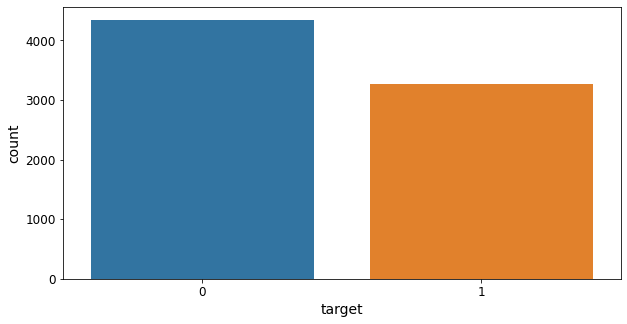

In [5]:
plt.figure(figsize=(10,5))
sns.countplot(data=train, x='target');

Good, it seems the target variable <b>does not</b> have a string inbalance, with a ratio of approximately <b>6:4</b>.

Analyzing the <b>keyword</b> column...

In [6]:
train['keyword'].isnull().sum()

61

There are not a lot of missing keywords... which is good. Let's replace the missing keyword with the word ``missing``.

In [7]:
train['keyword'] = train['keyword'].fillna('missing')
test['keyword'] = test['keyword'].fillna('missing')
train['keyword'].unique()

array(['missing', 'ablaze', 'accident', 'aftershock',
       'airplane%20accident', 'ambulance', 'annihilated', 'annihilation',
       'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack',
       'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism',
       'blaze', 'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard',
       'blood', 'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail'

In [8]:
train['keyword'].nunique()

222

In [9]:
train[train['target'] == 1]['keyword'].value_counts()

missing        42
derailment     39
outbreak       39
wreckage       39
oil%20spill    37
               ..
body%20bags     1
epicentre       1
electrocute     1
body%20bag      1
blazing         1
Name: keyword, Length: 221, dtype: int64

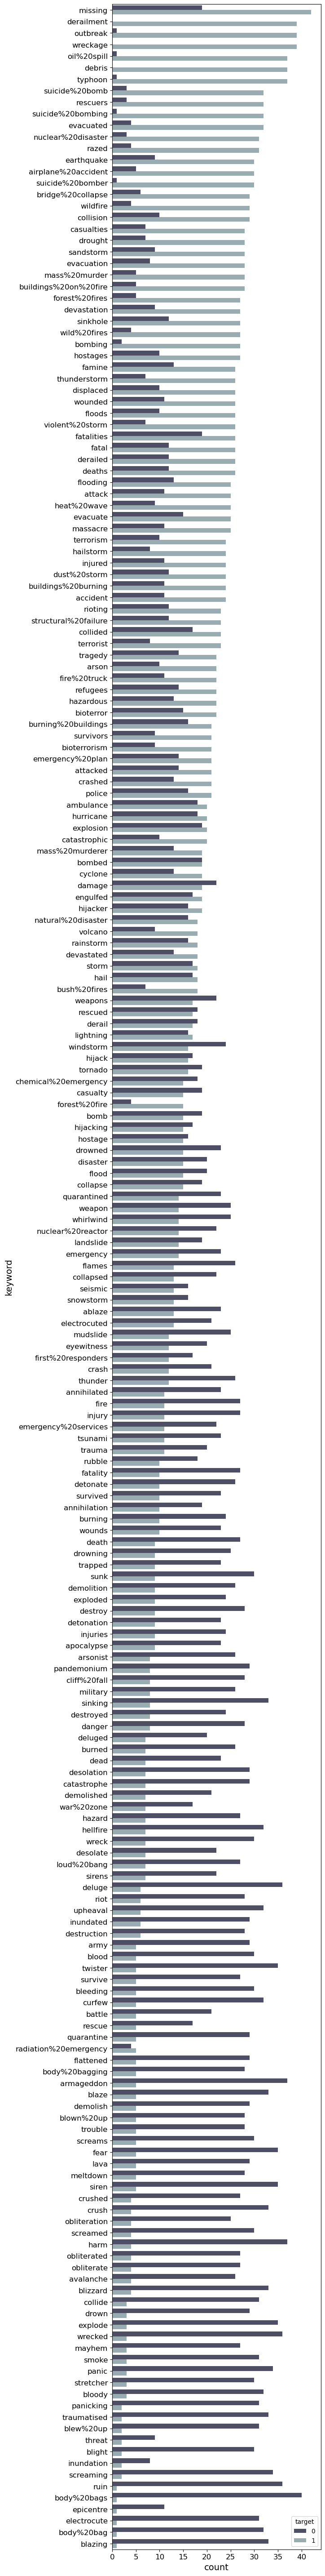

In [10]:
plt.figure(figsize=(6,75), dpi=100)
sns.countplot(data=train, y='keyword', hue='target',
              order=train[train['target'] == 1]['keyword'].value_counts().index,
             palette='bone');

The countplot clearly shows several keyword values have a <b>big impact on the target feature</b>.

Let's analyze <b>location</b>...

In [11]:
train['location'].isnull().sum()

2533

In [12]:
print(f"Missing location values: {train['location'].isnull().sum()/len(train['location'])*100:.1f}%")

Missing location values: 33.3%



Approximately $\frac{1}{3}$ of the location is missing... this may be a significant measure to discard this input value.

In [13]:
train['location'].nunique()

3341

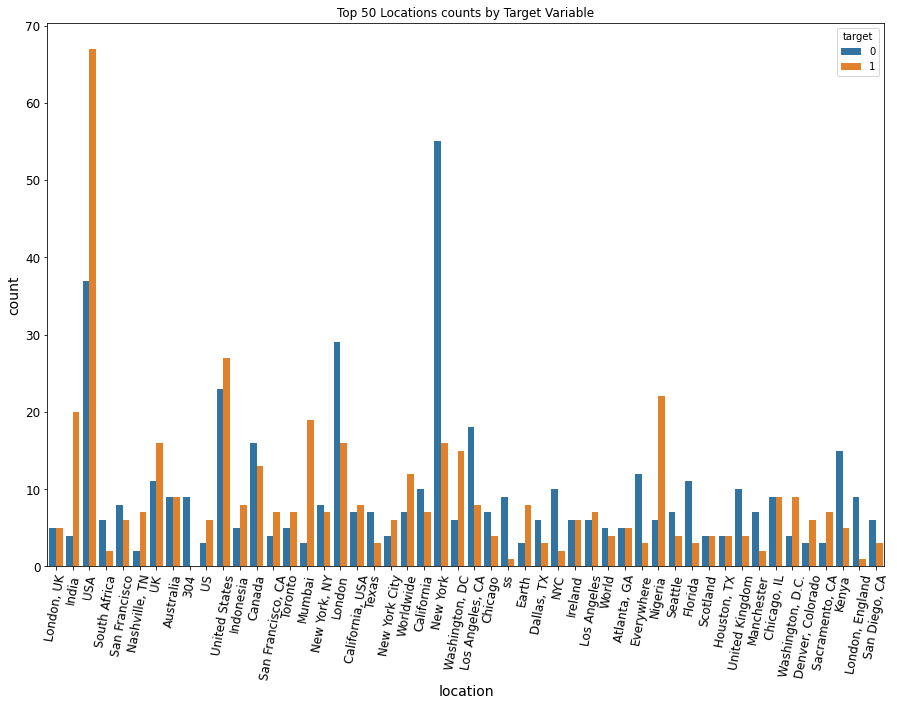

In [14]:
top_50_locations = train['location'].value_counts(normalize=True).head(50).index
plt.figure(figsize=(15,10))
plt.title("Top 50 Locations counts by Target Variable")
sns.countplot(data=train[train['location'].isin(top_50_locations)], x='location', hue='target')
plt.xticks(rotation=80);

The location independent variable is polluted, and there are several values that relate to each other, like 'United Kingdom', 'UK', 'London, UK', 'London', and 'London, England'. Some others are meaningless (e.g. '304', 'ss' or 'Earth'). This variable seems of no use and will be ignored.

## Pre-processing

#### Auxiliary functions

As part of cleaning up the text, we use ``stopwords`` method from ``nltk`` package to remove the common words, that are not useful to determine the target variable and just add noise.

More details on stop words, please check the following <a href="https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a">link</a>.

Also, a little investigation and I found an interesting article regarding what to consider when removing stop words blindly. It may change the outcome. This is how I added the ``decontracted`` function below. More details, check the following <a href="https://dev.to/sunilaleti/don-t-blindly-remove-stopwords-in-sentiment-analysis-3nok">link</a>.

In [32]:
stop_words = stopwords.words('english')
wlem = WordNetLemmatizer()
#stop_words.append('i\'m') # I saw this abbreviation, but it is not in the list of stop-words, so I added it manually

def decontracted(text: str) -> str:
    # text = text.str.replace(r"\'t", "not", regex=True)
    # text = text.str.replace(r"\'re", " are", regex=True)
    # text = text.str.replace(r"\'s", " is", regex=True)
    # text = text.str.replace(r"\'d", " would", regex=True)
    # text = text.str.replace(r"\'ll", " will", regex=True)
    # text = text.str.replace(r"\'ve", " have", regex=True)
    # text = text.str.replace(r"\'m", " am", regex=True)
    text = re.sub(r"\'t", "not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

def pre_processing(s: pd.Series) -> list:
    l = []
    for i, text in enumerate(s):
        text = text.lower() # convert all characterd to lowercase  
        text = decontracted(text) # expand contracted text forms

        # remove stop words
        # pattern = r'\b(?:{})\b'.format('|'.join(stop_words))
        # text = text.str.replace(pattern, '', regex=True)
        # text = text.str.replace(r'\s+', ' ', regex=True)
        text = ' '.join([char for char in list(text.split()) if char not in stop_words]) # remove stop words

        #text = text.str.replace('http', '')  # remove http word
        text = ' '.join(['' if 'http' in char else char for char in text.split()]) # remove http word

        # add an extra space in punctuation characters (e.g. "one,two,three" becomes "one, two, three")
        text = ''.join([char+' ' if char in string.punctuation else char for char in text]) 

        # remove all characters that are not alpha, numbers or space
        text = ''.join([char for char in text if char in string.ascii_lowercase or char in ' ' or  char in string.digits])
        text = ' '.join(text.split()) # remove extra space between words
        text = ' '.join([wlem.lemmatize(word) for word in text.split()])
        #text = text.split()
        #text = tf.strings.split(text)
        #text = text.to_tensor()
        l.append(text)
    return l

def tokenize(input_data):
    m_tokenizer = text.Tokenizer(num_words=None, split=' ', char_level=False, oov_token=None)
    m_tokenizer.fit_on_texts(input_data)
    data_encoded = m_tokenizer.texts_to_sequences(input_data)
    vocab_size = len(m_tokenizer.word_index) + 1
    
    for i in range(0, 5):
        print(f"Cleaned[{i}]: {input_data[i]}")
        print(f"Tokens [{i}]: {data_encoded[i]}\n")
    return data_encoded, vocab_size

#### Generate the train and test datasets

In [16]:
train_list = pre_processing(train['text'].copy())
test_list = pre_processing(test['text'].copy())

In [17]:
for i in range(0, 5):
    print(f"Original tweet[{i+1}]: {train.iloc[i]['text']}")
    print(f"Pre-processed tweet[{i+1}]: {train_list[i]}\n")

Original tweet[1]: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Pre-processed tweet[1]: deed reason earthquake may allah forgive u

Original tweet[2]: Forest fire near La Ronge Sask. Canada
Pre-processed tweet[2]: forest fire near la ronge sask canada

Original tweet[3]: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Pre-processed tweet[3]: resident asked ishelter place notified officer evacuation shelter place order expected

Original tweet[4]: 13,000 people receive #wildfires evacuation orders in California 
Pre-processed tweet[4]: 13 000 people receive wildfire evacuation order california

Original tweet[5]: Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
Pre-processed tweet[5]: got sent photo ruby alaska smoke wildfire pours school



In [33]:
train_encoded, vocab_size = tokenize(train_list)
# m_tokenizer = text.Tokenizer(num_words=None, split=' ', char_level=False, oov_token=None)
# m_tokenizer.fit_on_texts(train_list)
# train_encoded = m_tokenizer.texts_to_sequences(train_list)
# vocab_size = len(m_tokenizer.word_index) + 1

# for i in range(0, 5):
#     print(f"Cleaned tweet[{i}]: {train_list[i]}")
#     print(f"Tokens [{i}]: {train_encoded[i]}\n")
# m_tokenizer.fit_on_texts(list(train['text_cleaned']))
# X_train = []
# for row in train['text_cleaned']:
#     X_train.append(m_tokenizer.texts_to_sequences(row))

Cleaned[0]: deed reason earthquake may allah forgive u
Tokens [0]: [4212, 500, 180, 80, 1509, 4213, 4]

Cleaned[1]: forest fire near la ronge sask canada
Tokens [1]: [118, 1, 171, 619, 6215, 6216, 1148]

Cleaned[2]: resident asked ishelter place notified officer evacuation shelter place order expected
Tokens [2]: [1641, 1510, 6217, 501, 6218, 342, 181, 2027, 501, 343, 1029]

Cleaned[3]: 13 000 people receive wildfire evacuation order california
Tokens [3]: [728, 2744, 10, 4214, 90, 181, 343, 33]

Cleaned[4]: got sent photo ruby alaska smoke wildfire pours school
Tokens [4]: [45, 1149, 116, 6219, 1642, 207, 90, 6220, 112]



#### Split the datasets into train and test sets

In [19]:
X = train_encoded
y = list(train['target'])
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train_tensor = tf.ragged.constant(X_train)
y_train_tensor = tf.ragged.constant(y_train)
X_test_tensor = tf.ragged.constant(X_test)
y_test_tensor = tf.ragged.constant(y_test)

## Create the Model

#### Auxiliary functions

In [66]:
def create_model(vocab_size=None, nn_units=[], fn_units=[], use_lstm=True):
    model = Sequential(Embedding(vocab_size, nn_units[0]))
    for i in range(1, len(nn_units)):
        ret_seq = (i < (len(nn_units)-1))
        if use_lstm:
            model.add(Bidirectional(LSTM(nn_units[i], return_sequences=ret_seq)))
        else:
            model.add(GRU(nn_units[i], return_sequences=ret_seq))
            
    for i in range(0, len(fn_units)-1):
        model.add(Dense(fn_units[i], activation='relu'))
        model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
    
    model.summary()
    #keras.utils.plot_model(model, "LSTMBinaryClassificationModel.png", show_shapes=True) 
    return model

def fit(model, X, y, X_val=None, y_val=None, epochs=10, batch_size=None):
    params = {'epochs': epochs, 'batch_size' : batch_size, 'verbose' : 1}
    if X_val is not None and y_val is not None:
        params['validation_data'] = (X_val, y_val)
    history = model.fit(X, y, **params)
    
    return pd.DataFrame(history.history)

def eval(history=None):
    if history is None:
        return

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

    # Accuracy
    history[['accuracy', 'val_accuracy']].plot(ax=ax1);
    ax1.set_title("Model Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend(['train', 'test'], loc='center right');

    # Loss
    history[['loss', 'val_loss']].plot(ax=ax2);
    ax2.set_title("Model Loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend(['train', 'test'], loc='center right');

#### Model 1 - 2 x LSTM

In [67]:
model1 = create_model(vocab_size=vocab_size, nn_units=[64, 64, 32], fn_units=[1])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          1013440   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,120,769
Trainable params: 1,120,769
Non-trainable params: 0
_________________________________________________________________


In [68]:
hist_1 = fit(model1, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 5)

Epoch 1/5


C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("Adam/gradients/concat_2:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_3/bidirectional_2/forward_lstm_2/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


191/191 [==============================] - 57s 262ms/step - loss: 0.6853 - accuracy: 0.5686 - val_loss: 0.6650 - val_accuracy: 0.5942
Epoch 2/5
191/191 [==============================] - 54s 284ms/step - loss: 0.5134 - accuracy: 0.7839 - val_loss: 0.4998 - val_accuracy: 0.7853
Epoch 3/5
191/191 [==============================] - 57s 300ms/step - loss: 0.3351 - accuracy: 0.8783 - val_loss: 0.5066 - val_accuracy: 0.7820
Epoch 4/5
191/191 [==============================] - 59s 308ms/step - loss: 0.2448 - accuracy: 0.9204 - val_loss: 0.5616 - val_accuracy: 0.7781
Epoch 5/5
191/191 [==============================] - 61s 320ms/step - loss: 0.1842 - accuracy: 0.9424 - val_loss: 0.6330 - val_accuracy: 0.7689


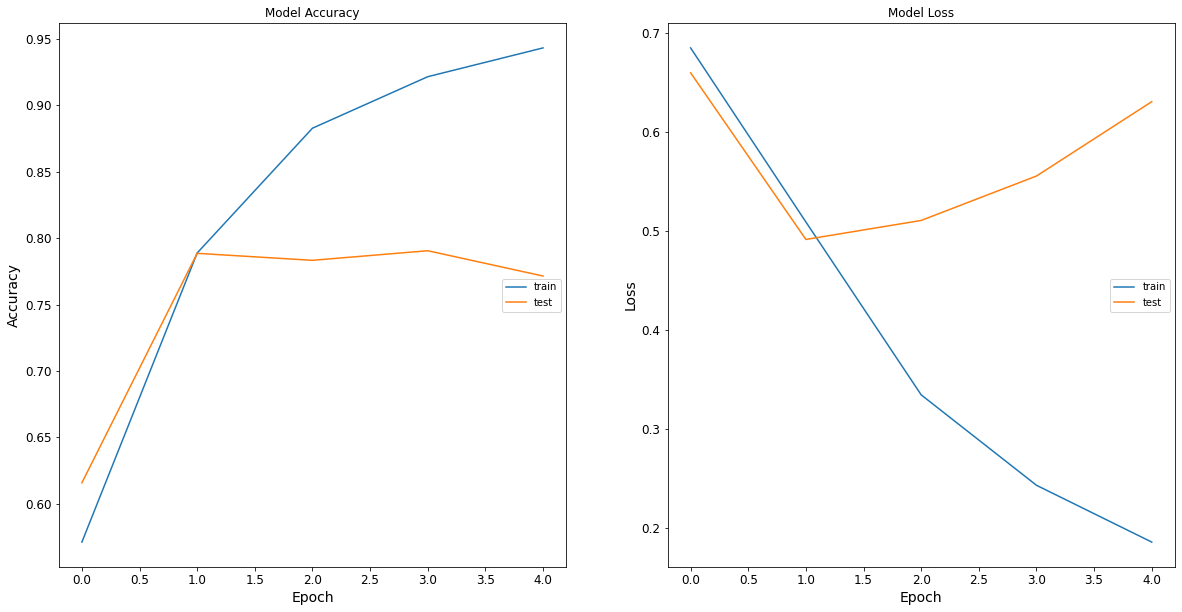

In [24]:
eval(hist_1)

#### Model 2 - 3x GRU, 1x Dense

In [69]:
model2 = create_model(vocab_size=vocab_size, nn_units=[128, 128, 128], fn_units=[64, 1], use_lstm=False)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         2026880   
                                                                 
 gru_5 (GRU)                 (None, None, 128)         99072     
                                                                 
 gru_6 (GRU)                 (None, 128)               99072     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,233,345
Trainable params: 2,233,345
No

In [70]:
hist_2 = fit(model2, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 5)

Epoch 1/5


C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_4/gru_5/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_4/gru_5/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_4/gru_5/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


191/191 [==============================] - 37s 178ms/step - loss: 0.6824 - accuracy: 0.5701 - val_loss: 0.6507 - val_accuracy: 0.6067
Epoch 2/5
191/191 [==============================] - 38s 198ms/step - loss: 0.4781 - accuracy: 0.7975 - val_loss: 0.4530 - val_accuracy: 0.8030
Epoch 3/5
191/191 [==============================] - 38s 199ms/step - loss: 0.2953 - accuracy: 0.8882 - val_loss: 0.4721 - val_accuracy: 0.7919
Epoch 4/5
191/191 [==============================] - 36s 187ms/step - loss: 0.2063 - accuracy: 0.9287 - val_loss: 0.5406 - val_accuracy: 0.7866
Epoch 5/5
191/191 [==============================] - 37s 196ms/step - loss: 0.1418 - accuracy: 0.9524 - val_loss: 0.6906 - val_accuracy: 0.7564


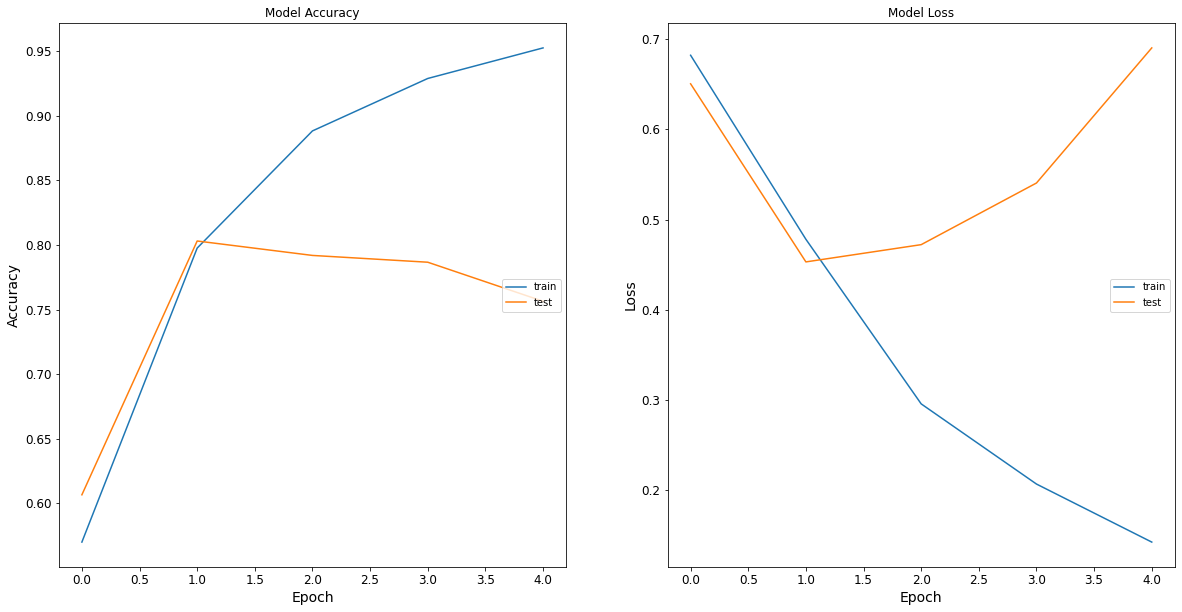

In [71]:
eval(hist_2)

#### Model 3 - 4x LSTM, 2x Dense

In [72]:
model3 = create_model(vocab_size=vocab_size, nn_units=[128, 128, 128, 128], fn_units=[64, 32, 1], use_lstm=False)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 128)         2026880   
                                                                 
 gru_7 (GRU)                 (None, None, 128)         99072     
                                                                 
 gru_8 (GRU)                 (None, None, 128)         99072     
                                                                 
 gru_9 (GRU)                 (None, 128)               99072     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)               

In [73]:
hist_3 = fit(model3, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 25)

Epoch 1/25


C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_5/gru_7/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_5/gru_7/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_5/gru_7/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


191/191 [==============================] - 62s 299ms/step - loss: 0.6871 - accuracy: 0.5624 - val_loss: 0.6734 - val_accuracy: 0.5739
Epoch 2/25
191/191 [==============================] - 59s 306ms/step - loss: 0.5405 - accuracy: 0.7601 - val_loss: 0.4825 - val_accuracy: 0.7787
Epoch 3/25
191/191 [==============================] - 68s 356ms/step - loss: 0.3537 - accuracy: 0.8760 - val_loss: 0.5012 - val_accuracy: 0.7853
Epoch 4/25
191/191 [==============================] - 61s 320ms/step - loss: 0.2606 - accuracy: 0.9153 - val_loss: 0.5604 - val_accuracy: 0.7689
Epoch 5/25
191/191 [==============================] - 57s 297ms/step - loss: 0.1876 - accuracy: 0.9425 - val_loss: 0.6597 - val_accuracy: 0.7518
Epoch 6/25
191/191 [==============================] - 57s 301ms/step - loss: 0.1391 - accuracy: 0.9591 - val_loss: 0.7987 - val_accuracy: 0.7433
Epoch 7/25
191/191 [==============================] - 58s 302ms/step - loss: 0.1098 - accuracy: 0.9698 - val_loss: 0.9372 - val_accuracy: 0.7

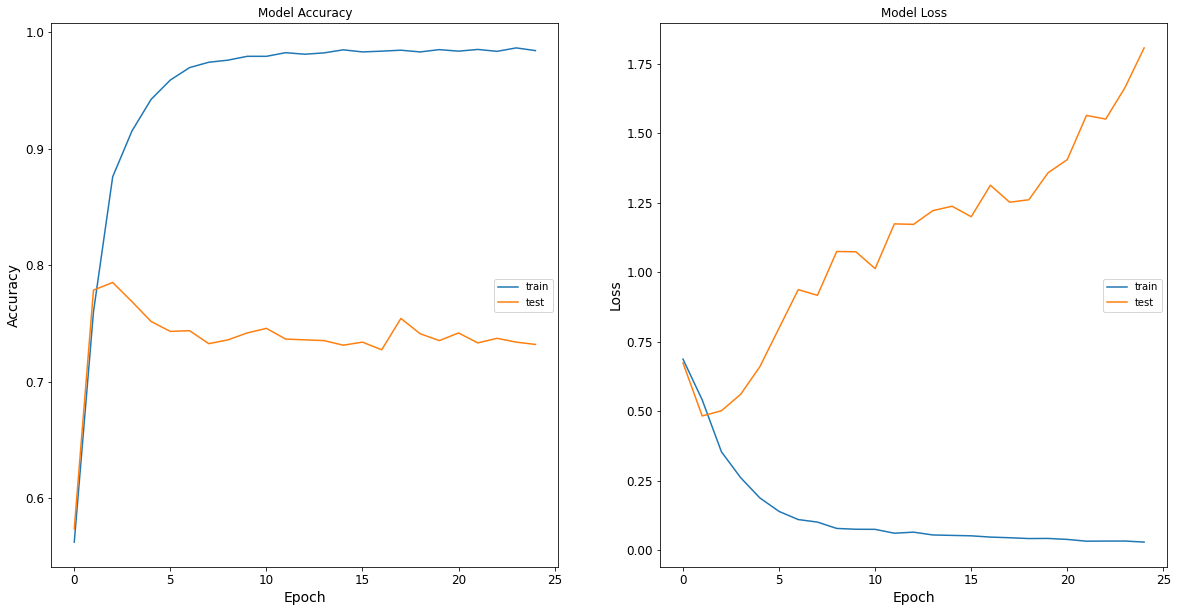

In [74]:
eval(hist_3)

## Predictions

#### Pre-process the test data

In [75]:
test_encoded, vocab_size_test = tokenize(test_list)
test_list_tensor = tf.ragged.constant(test_encoded)
ids = list(test['id'].astype(int))

Cleaned[0]: happened terrible car crash
Tokens [0]: [509, 923, 56, 41]

Cleaned[1]: heard earthquake different city stay safe everyone
Tokens [1]: [211, 186, 1806, 123, 676, 824, 376]

Cleaned[2]: forest fire spot pond goose fleeing across street cannot save
Tokens [2]: [68, 1, 825, 1457, 3693, 3694, 924, 326, 74, 233]

Cleaned[3]: apocalypse lighting spokane wildfire
Tokens [3]: [212, 2400, 3695, 98]

Cleaned[4]: typhoon soudelor kill 28 china taiwan
Tokens [4]: [213, 677, 88, 1807, 234, 1458]



In [76]:
y_pred1 = model1.predict(test_list_tensor)
y_pred2 = model2.predict(test_list_tensor)
y_pred3 = model3.predict(test_list_tensor)

## Submissions

#### Auxiliary functions

In [77]:
def submission_file(X, y, filename=None):
    cols = ['id', 'target']
    data = np.column_stack((X, y))
    df = pd.DataFrame(data, columns=cols, dtype=int)
    df.set_index('id', inplace=True)
    df.to_csv(path_or_buf=filename, encoding='utf-8')

#### Submit Model 1

In [78]:
submission_file(ids, y_pred1.round(), "submission_1.csv")

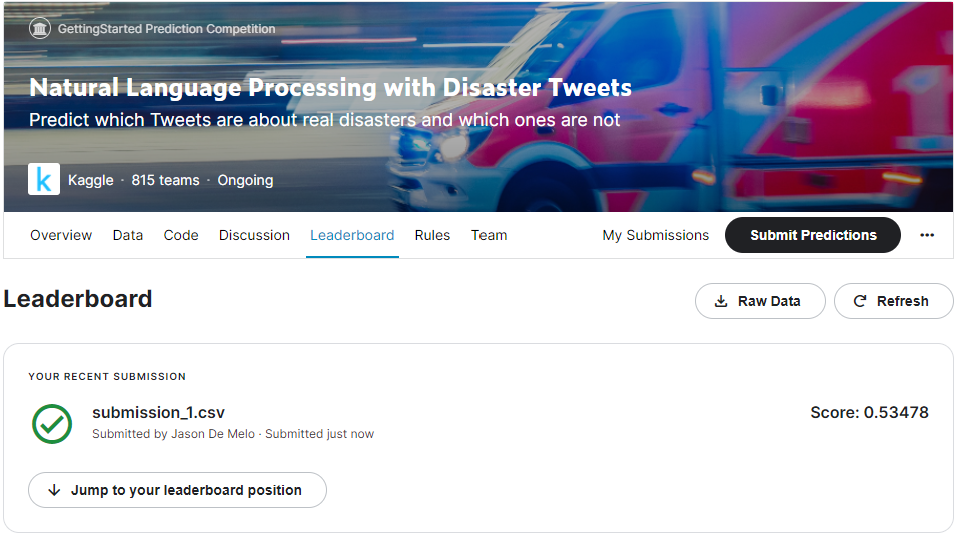

In [81]:
Image("submission1.png")

#### Submit Model 2

In [79]:
submission_file(ids, y_pred2.round(), "submission_2.csv")

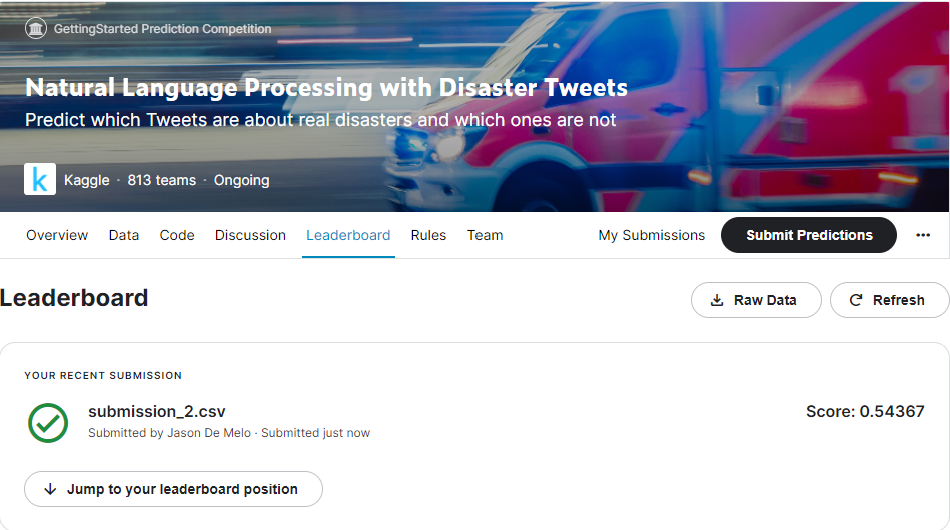

In [64]:
Image("submission2.png")

#### Submit Model 3

In [80]:
submission_file(ids, y_pred3.round(), "submission_3.csv")

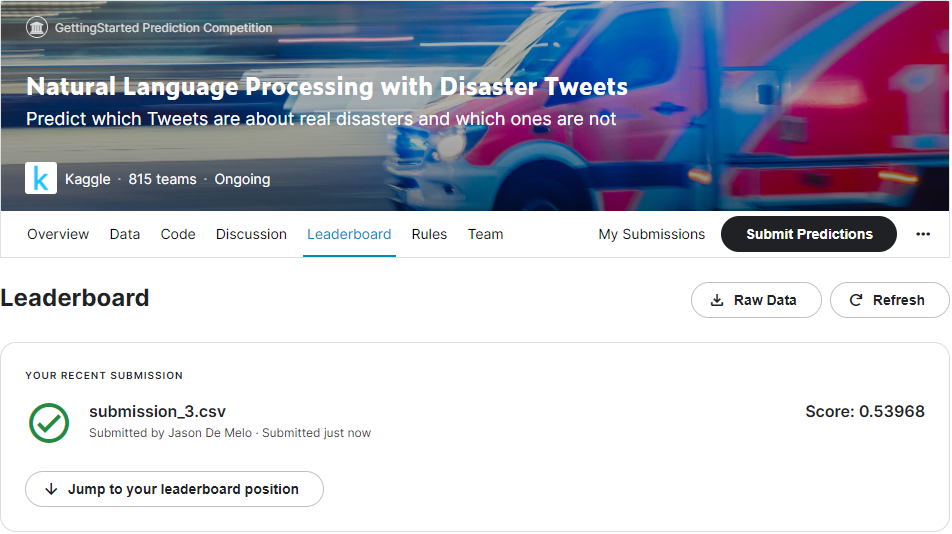

In [82]:
Image("submission3.png")

## Conclusion

As usual, more complex models does not necessarily means better results. Model 3 with 4 LSTM layers and 2 Dense layers and several nodes is the most complex model I was able to create, but it did not give me the best result.

For this assignment, simpler models with less epochs gave me better answers. That is a bit surprising, actually. It makes me believe there is a lot of room for improvement. The models clearly overfit, when you check on the Accuracy and Loss graphs.